In [1]:
%matplotlib inline
import operator

import numpy as np
import pandas as pd
import networkx as nx

from scipy.stats import pearsonr
from itertools import product
from itertools import combinations
from itertools import permutations

import matplotlib.pyplot as plt

**Toy-Example**:<br />
Random network G=(N,p)<br />
Binary node-attribute: color

In [2]:
N=20
p=0.4
attribute = 'color'
G = nx.erdos_renyi_graph(n=N,p=p)
nx.set_node_attributes(G, name=attribute, values={i:np.random.choice([0,1]) for i in G.nodes()})
print(nx.info(G))

Name: 
Type: Graph
Number of nodes: 20
Number of edges: 78
Average degree:   7.8000


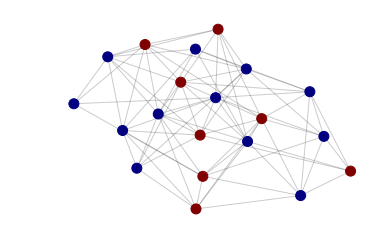

In [3]:
pos = nx.spring_layout(G)
ec = nx.draw_networkx_edges(G, pos, alpha=0.2)
nc = nx.draw_networkx_nodes(G, pos, 
                            nodelist=G.nodes(), 
                            node_color=[data[attribute] for n,data in G.nodes(data=True)], 
                            with_labels=False, 
                            node_size=100, 
                            cmap=plt.cm.jet)
plt.axis('off')
plt.show()

***Pearson Correlation Coefficient***

Implemented from scratch

In [4]:
def correlation(e):
    numerator = sum([(j*k)*(e.loc[j,k]-(e.loc[j,:].sum()*e.loc[:,k].sum())) for j,k in product(e.index,e.columns)])
    denominator_j = sum([(j**2)*e.loc[j,:].sum() for j in e.index]) - (sum([j*e.loc[j,:].sum() for j in e.index]))**2
    denominator_k = sum([(k**2)*e.loc[:,k].sum() for k in e.columns]) - (sum([k*e.loc[:,k].sum() for k in e.columns]))**2
    return numerator / np.sqrt(denominator_j*denominator_k)

***Degree-Degree Correlation***

In [5]:
def degree_correlation_matrix(G):
    pairs = [(G.degree(edge[0]),G.degree(edge[1])) for edge in G.edges()]
    index = list(zip(*pairs))
    index = sorted(set(index[0])|set(index[1]))
    
    df = pd.DataFrame(index=index,columns=index)
    df.fillna(0,inplace=True)
    for p in pairs:
        df.loc[p[0],p[1]] += 1
    df /= df.values.sum()
    return df

In [6]:
e=degree_correlation_matrix(G)
correlation(e)

-0.072072765639807329

In [7]:
v1,v2=zip(*[(G.degree(e[0]),G.degree(e[1])) for e in G.edges()])
pearsonr(v1,v2)

(-0.07207276563980955, 0.53061407695253915)

In [8]:
nx.degree_assortativity_coefficient(G)

-0.098388882056331395

***Attribute-Attribute Correlation***

In [9]:
def attribute_correlation_matrix(G, attribute):
    node_attributes = nx.get_node_attributes(G=G, name=attribute)
    if not node_attributes:
        raise Exception('attribute \'{}\' does not exist.'.format(attribute))
        
    pairs = [(G.node[edge[0]][attribute],G.node[edge[1]][attribute]) for edge in G.edges()]
    index = sorted(set(node_attributes.values()))

    df = pd.DataFrame(index=index,columns=index)
    df.fillna(0,inplace=True)
    for p in pairs:
        df.loc[p[0],p[1]] += 1
    df /= df.values.sum()
    return df

In [10]:
e=attribute_correlation_matrix(G,attribute)
correlation(e)

-0.11884984845689821

In [11]:
v1,v2=zip(*[(G.node[e[0]][attribute],G.node[e[1]][attribute]) for e in G.edges()])
pearsonr(v1,v2)

(-0.11884984845689815, 0.30002235134960198)

***Degree-Attribute Correlation***

In [12]:
def degree_attribute_correlation_matrix(G, attribute):
    node_attributes = nx.get_node_attributes(G=G, name=attribute)
    if not node_attributes:
        raise Exception('attribute \'{}\' does not exist.'.format(attribute))
        
    pairs = [(G.degree(n),G.node[n][attribute]) for n in G.nodes()]
    index, columns = zip(*pairs)
    
    index = sorted(set(index))
    columns = sorted(set(columns))
    
    df = pd.DataFrame(index=index,columns=columns)
    df.fillna(0,inplace=True)
    for p in pairs:
        df.loc[p[0],p[1]] += 1
    df /= df.values.sum()
    return df

In [13]:
e=degree_attribute_correlation_matrix(G,attribute)
correlation(e)

-0.023728949893812822

In [14]:
v1,v2=zip(*[(G.degree(n),G.node[n][attribute]) for n in G.nodes()])
pearsonr(v1,v2)

(-0.023728949893812478, 0.92090040776750537)

***Degree-Degree Monophily Correlation***

In [15]:
def degree_monophily_correlation_matrix(G):
    pairs = [(G.degree(j),G.degree(k)) for i in G.nodes() for (j,k) in combinations(G.neighbors(i),2)]
    index = list(zip(*pairs))
    index = sorted(set(index[0])|set(index[1]))
    
    df = pd.DataFrame(index=index,columns=index)
    df.fillna(0,inplace=True)
    for p in pairs:
        df.loc[p[0],p[1]] += 1
    df /= df.values.sum()
    return df

In [16]:
e=degree_monophily_correlation_matrix(G)
correlation(e)

-0.063426536262687516

In [17]:
v1,v2 = zip(*[(G.degree(j),G.degree(k)) for i in G.nodes() for (j,k) in combinations(G.neighbors(i),2)])
pearsonr(v1,v2)

(-0.063426536262690833, 0.13384724655399727)

***Attribute-Attribute Monophily correlation***

In [18]:
def attribute_monophily_correlation_matrix(G, attribute):
    node_attributes = nx.get_node_attributes(G=G, name=attribute)
    if not node_attributes:
        raise Exception('attribute \'{}\' does not exist.'.format(attribute))
        
    pairs = [(G.node[j][attribute],G.node[k][attribute]) for i in G.nodes() for (j,k) in combinations(G.neighbors(i),2)]
    index = sorted(set(node_attributes.values()))

    df = pd.DataFrame(index=index,columns=index)
    df.fillna(0,inplace=True)
    for p in pairs:
        df.loc[p[0],p[1]] += 1
    df /= df.values.sum()
    return df

In [19]:
e=attribute_monophily_correlation_matrix(G,attribute)
correlation(e)

-0.060738387058674397

In [20]:
v1,v2 = zip(*[(G.node[j][attribute],G.node[k][attribute]) for i in G.nodes() for (j,k) in combinations(G.neighbors(i),2)])
pearsonr(v1,v2)

(-0.060738387058674417, 0.151159913838875)